In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import math as m

import scipy.io
from scipy.signal import butter, lfilter
from scipy.interpolate import griddata
from scipy.misc import bytescale

from itertools import chain
from functools import reduce

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, scale
from sklearn.metrics import roc_auc_score

import re
import h5py
import csv

import matplotlib.pyplot as plt

plt.style.use('ggplot')

np.random.seed(777)
%matplotlib inline

In [2]:
TRAIN_FILE = "train.h5"
TEST_FILE = "test.h5"
SAMPLING_RATE = 250

In [3]:
CHANNEL_NAMES = np.array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'A1', 'O1', 'Cz', 'Oz', 'Fz', 'Pz', 'O2', 'A2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6', 'AUX'])
CHANNELS_TO_DISCARD = ['A1', 'A2', 'AUX']
EYE_CHANNEL = "Fp1"
CSP_FREQUENCES = [(6,10),(8,12),(10,14),(12,16),(14,18),(16,20),(18,22),(20,24),
                     (22,26),(24,28),(26,30),(28,32),(30,34),(32,36),(34,38)]

In [4]:
def butter_bandpass(lowcut, highcut, sampling_rate, order=5):
    """
    For a given order (5 by default), computes numerator (b)
    and denominator (a) polynomials
    of the IIR filter (bandpass between lowcut and highcut).
    """
    nyq_freq = sampling_rate*0.5
    low = lowcut/nyq_freq
    high = highcut/nyq_freq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_high_low_pass(lowcut, highcut, sampling_rate, order=5):
    """
    For a given order (5 by default), computes numerator (b_high, b_low)
    and denominator (a_high, a_low) polynomials of the IIR filters
    (highpass for lowcut, lowpass for highcut).
    """
    nyq_freq = sampling_rate*0.5
    lower_bound = lowcut/nyq_freq
    higher_bound = highcut/nyq_freq
    b_high, a_high = butter(order, lower_bound, btype='high')
    b_low, a_low = butter(order, higher_bound, btype='low')
    return b_high, a_high, b_low, a_low

def butter_bandpass_filter(data, lowcut, highcut, sampling_rate, order=5, how_to_filt = 'separately'):
    """
    Applies Butterworth bandpass filter (with a given order, 5 by default) to the data.
    If how_to_filt = 'separately', applies highpass than lowpass, and thus results
        in bandpass between lowcut and highcut.
    If how_to_filt == 'simultaneously', applies bandpass directly.
    """
    if how_to_filt == 'separately':
        b_high, a_high, b_low, a_low = butter_high_low_pass(lowcut, highcut, sampling_rate, order=order)
        y = lfilter(b_high, a_high, data)
        y = lfilter(b_low, a_low, y)
    elif how_to_filt == 'simultaneously':
        b, a = butter_bandpass(lowcut, highcut, sampling_rate, order=order)
        y = lfilter(b, a, data)
    return y

In [5]:
def remove_outliers(data, iter_numb):
    """
    Repetitively (specified by iter_numb) applies outliers removal to the data:
    deletes samples which power deviates more than 2.5 SDs from the mean.
    """
    data_pwr = np.sqrt(np.sum(data**2, 0))
    mask = np.ones(data.shape[1], dtype=np.bool)
    for i in range(iter_numb):
        X_mean = np.mean(data_pwr[mask])
        X_std = np.std(data_pwr[mask])
        mask &= np.abs(data_pwr - X_mean) < 2.5*np.abs(X_std)
        print('Samples left after outliers removal: %d' % mask.sum())
    return mask

def remove_eog_simple(data, channel_names, number_artefact_components=3):
    """
    Blinks and eye artefacts removal by singular value decomposition.
    
    Arguments:
    data: EEG data, numpy array [n_channels, n_samples]
    eyechan: channel nummer used for artefacts detection
    number_artefact_components: number of eigenvalues used - the number
       of components the artefacts are presumed to have
       
    Returns artefact-free EEG time series and the matrix of corresponding transformation
    """
    only_eye_chan = data[channel_names == EYE_CHANNEL, :]
    exceed_mask = only_eye_chan > 3*np.mean(np.absolute(only_eye_chan))
    print('Number of samples identified as containing eye artefacts: %d' % np.sum(exceed_mask))
    U, S, V = np.linalg.svd(data[:, exceed_mask[0,:]], full_matrices=True)
    M_eog = np.eye(U.shape[0])-np.dot(U[:,0:number_artefact_components],U[:,0:number_artefact_components].T)
    
    return np.dot(M_eog, data), M_eog

In [6]:
def outer_n(n):
    return np.array(list(range(n))+list(range(-n,0)))

def whitener(C, rtol=1e-15):
    e, E = np.linalg.eigh(C)
    return reduce(np.dot, [E, np.diag(np.where(e > np.max(e) * rtol, e, np.inf)**-0.5), E.T])

def csp_base(C_a, C_b):
    P = whitener(C_a + C_b)
    P_C_b = reduce(np.dot, [P, C_b, P.T])
    _, _, B = np.linalg.svd((P_C_b))
    return np.dot(B, P.T)

def csp(C_a, C_b, m):
    W = csp_base(C_a, C_b)
    assert W.shape[1] >= 2*m
    return W[outer_n(m)]

In [7]:
def filter_eeg(eeg_data, sampling_rate, channel_names):
    # Prefilter eeg data
    eeg_data = butter_bandpass_filter(eeg_data, 0.5, 45, sampling_rate, order=5, how_to_filt='separately')
    
    # Remove empty channels
    # Detect constant (zero) channels
    channels_mask = np.ones(len(channel_names), dtype=np.bool)
    for channel in CHANNELS_TO_DISCARD:
        channels_mask &= (channel_names != channel)
        
    nozeros_mask = np.sum(eeg_data[:, :sampling_rate * 2], 1) != 0
    without_emp_mask = nozeros_mask & channels_mask
    
    # Remove constant (zero) channels and prespecified channels
    eeg_data = eeg_data[without_emp_mask, :]
    channel_names = channel_names[without_emp_mask]
    
    return eeg_data, channel_names

In [8]:
numbergetter = re.compile(r"\d+$")
def get_tail_number(string):
    return int(numbergetter.findall(string)[0])

In [9]:
import mne

def load_raw_data(data, selected_channels, montage):
    info = mne.create_info(ch_names=list(selected_channels), 
                           sfreq=SAMPLING_RATE,
                           ch_types='eeg',
                           montage=montage)
    
    return mne.io.RawArray(data, info=info)

def load_montage_information(filename):
    assert filename.endswith('.mat')
    
    mat = sp.io.loadmat(filename)    
    point_labels = [mat[0] for mat in mat['labels']]
    point_data = [mat['x_coord'], mat['y_coord'], mat['z_coord']]
    points = np.concatenate(point_data, axis=1)
    
    assert len(points) == len(point_labels)
    return mne.channels.Montage(pos=points, ch_names=point_labels, kind=None, selection=range(len(points)))

def process_raw_data(eeg_data):
    
    filtered_eeg, selected_channels = filter_eeg(eeg_data, SAMPLING_RATE, CHANNEL_NAMES)
    
    # Remove outliers; remove artefacts (blinks, eye movements)
    eye_channel_index = (selected_channels == EYE_CHANNEL)
    selected_items = remove_outliers(filtered_eeg, 7)
    filtered_eeg, M_eog = remove_eog_simple(filtered_eeg, selected_channels)
    
    return filtered_eeg, selected_channels

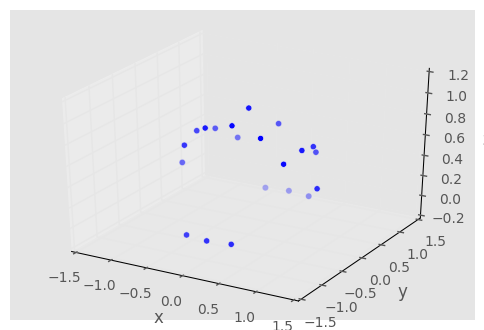

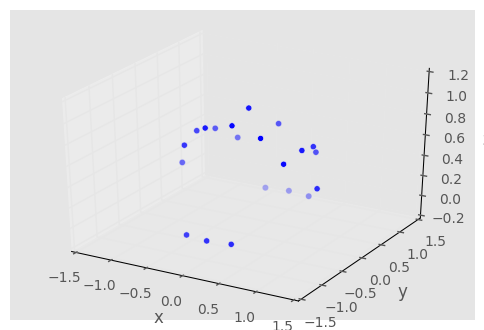

In [10]:
montage_data = load_montage_information('./electrode_locations_besa_unit_sphere.mat')
montage_data.plot()

In [11]:
train_data = {}
train_labels = {}

with h5py.File(TRAIN_FILE, 'r') as data_file:
    
    for subject, subject_data in data_file.items():
    
        data = subject_data['data'][()]    
    
        data, selected_channels = process_raw_data(data)
        train_data[subject] = {
            'data': load_raw_data(data, selected_channels, montage_data),
            'channels': selected_channels,
            'labels':  subject_data['labels'][()]
        } 
    
train_data

Samples left after outliers removal: 100390
Samples left after outliers removal: 98884
Samples left after outliers removal: 95921
Samples left after outliers removal: 93717
Samples left after outliers removal: 92399
Samples left after outliers removal: 91637
Samples left after outliers removal: 91217
Number of samples identified as containing eye artefacts: 1001
Creating RawArray with float64 data, n_channels=20, n_times=100826
    Range : 0 ... 100825 =      0.000 ...   403.300 secs
Ready.
Samples left after outliers removal: 54905
Samples left after outliers removal: 54110
Samples left after outliers removal: 52485
Samples left after outliers removal: 51002
Samples left after outliers removal: 49992
Samples left after outliers removal: 49364
Samples left after outliers removal: 48988
Number of samples identified as containing eye artefacts: 929
Creating RawArray with float64 data, n_channels=20, n_times=55306
    Range : 0 ... 55305 =      0.000 ...   221.220 secs
Ready.
Samples left

{'subject_0': {'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
         'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
        dtype='<U3'),
  'data': <RawArray  |  None, n_channels x n_times : 20 x 100826 (403.3 sec), ~15.4 MB, data loaded>,
  'labels': array([[0, 0, 0, ..., 2, 2, 2]])},
 'subject_1': {'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
         'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
        dtype='<U3'),
  'data': <RawArray  |  None, n_channels x n_times : 20 x 55306 (221.2 sec), ~8.5 MB, data loaded>,
  'labels': array([[2, 2, 2, ..., 2, 2, 2]])},
 'subject_2': {'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
         'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
        dtype='<U3'),
  'data': <RawArray  |  None, n_channels x n_times : 20 x 54457 (217.8 sec), ~8.4 MB, data loaded>,
  'labels': array([[0, 0, 0, ..., 

In [12]:
subject_data = train_data['subject_0']
subject_data

{'channels': array(['T5', 'T3', 'F7', 'F3', 'C3', 'P3', 'Fp1', 'Fpz', 'O1', 'Cz', 'Oz',
        'Fz', 'O2', 'Fp2', 'P4', 'C4', 'F4', 'F8', 'T4', 'T6'], 
       dtype='<U3'),
 'data': <RawArray  |  None, n_channels x n_times : 20 x 100826 (403.3 sec), ~15.4 MB, data loaded>,
 'labels': array([[0, 0, 0, ..., 2, 2, 2]])}

In [13]:
def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.

    :param pos: position in 3D Cartesian coordinates
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)

In [14]:
def gen_images(locs, features, img_size, normalize=True, n_bands=3,
               augment=False, pca=False, stdMult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param loc: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param img_size:    Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each feature over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param stdMult:     Standard deviation of noise for augmentation
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of th  e image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """

    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes

    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    
    n_colors = features.shape[1] // nElectrodes
    
    print('Colors: ' + str(n_colors))
    
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])

    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], stdMult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], stdMult, pca=False, n_components=n_components)

    nSamples = features.shape[0]
    
    minx, maxx = np.asscalar(min(locs[:, 0])), np.asscalar(max(locs[:, 0]))
    miny, maxy = np.asscalar(min(locs[:, 1])), np.asscalar(max(locs[:, 1]))
        
    print('Minx:', minx, 'Maxx:', maxx)
    print('Miny:', miny, 'Maxy:', maxy)
    print('Image size', img_size, 'x', img_size)
    
    # Interpolate the values
    grid_x, grid_y = np.meshgrid(np.linspace(minx, maxx, img_size), np.linspace(miny,maxy,img_size))
    
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, img_size, img_size]))

    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)

    for i in range(nSamples):
        
        if i%1000 == 0:
            print('Interpolating {0}/{1}\r'.format(i+1, nSamples))
        
        for c in range(n_colors):
            values = feat_array_temp[c][i, :]
            interpolated_values = griddata(locs, values, (grid_x, grid_y), method='cubic')
            temp_interp[c][i, :, :] = np.nan_to_num(interpolated_values)

    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
                
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]

In [15]:
import math as m
import numpy as np
import scipy.io
from sklearn.decomposition import PCA

def cart2sph(x, y, z):
    """
    Transform Cartesian coordinates to spherical
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :return: radius, elevation, azimuth
    """
    x2_y2 = x**2 + y**2
    r = m.sqrt(x2_y2 + z**2)                    # r
    elev = m.atan2(z, m.sqrt(x2_y2))            # Elevation
    az = m.atan2(y, x)                          # Azimuth
    return r, elev, az


def pol2cart(theta, rho):
    """
    Transform polar coordinates to Cartesian
    :param theta: angle value
    :param rho: radius value
    :return: X, Y
    """
    return rho * m.cos(theta), rho * m.sin(theta)


def augment_EEG(data, stdMult, pca=False, n_components=2):
    """
    Augment data by adding normal noise to each feature.
    :param data: EEG feature data as a matrix (n_samples x n_features)
    :param stdMult: Multiplier for std of added noise
    :param pca: if True will perform PCA on data and add noise proportional to PCA components.
    :param n_components: Number of components to consider when using PCA.
    :return: Augmented data as a matrix (n_samples x n_features)
    """
    augData = np.zeros(data.shape)
    if pca:
        pca = PCA(n_components=n_components)
        pca.fit(data)
        components = pca.components_
        variances = pca.explained_variance_ratio_
        coeffs = np.random.normal(scale=stdMult, size=pca.n_components) * variances
        for s, sample in enumerate(data):
            augData[s, :] = sample + (components * coeffs.reshape((n_components, -1))).sum(axis=0)
    else:
        # Add Gaussian noise with std determined by weighted std of each feature
        for f, feat in enumerate(data.transpose()):
            augData[:, f] = feat + np.random.normal(scale=stdMult*np.std(feat), size=feat.size)
    return augData


def augment_EEG_image(image, stdMult, pca=False, n_components=2):
    """
    Augment data by adding normal noise to each feature.
    :param image: EEG feature data as a a colored image [n_samples, n_colors, W, H]
    :param stdMult: Multiplier for std of added noise
    :param pca: if True will perform PCA on data and add noise proportional to PCA components.
    :param n_components: Number of components to consider when using PCA.
    :return: Augmented data as a matrix (n_samples x n_features)
    """
    augData = np.zeros((data.shape[0], data.shape[1], data.shape[2] * data.shape[3]))
    for c in range(image.shape[1]):
        reshData = np.reshape(data['featMat'][:, c, :, :], (data['featMat'].shape[0], -1))
        if pca:
            augData[:, c, :] = augment_EEG(reshData, stdMult, pca=True, n_components=n_components)
        else:
            augData[:, c, :] = augment_EEG(reshData, stdMult, pca=False)
    return np.reshape(augData, data['featMat'].shape)

In [21]:
def process_subject_data(subject_data):
    subject_df = subject_data['data'].to_data_frame(scale_time=1000)
    subject_df['label'] = subject_data['labels'][0]
    subject_df.index = pd.TimedeltaIndex(subject_df.index, unit='ms')
    subject_df = subject_df.resample('100ms').mean()
    features = subject_df.ix[:, subject_df.columns != 'label'].as_matrix()
    X = gen_images(electrode_positions, features, img_size=32, augment=True, pca=True, n_components=2)
    y = subject_df['label']
    return X, y

In [18]:
pos3d = montage_data.pos
pos2d = np.matrix([azim_proj(p) for p in pos3d])

print(pos2d.shape)

(21, 2)


In [19]:
used_electrodes_index = [c in subject_data['channels'] for c in montage_data.ch_names]
electrode_positions = pos2d[np.array(used_electrodes_index), :]

print(electrode_positions.shape)

(20, 2)


In [22]:
X_train, y_train = process_subject_data(train_data['subject_0'])

Converting time column to int64...
Colors: 1
Minx: -1.2042769839295635 Maxx: 1.2042769839295635
Miny: -1.6057024093979915 Maxy: 1.6057024093979915
Image size 32 x 32
Interpolating 1/4034
Interpolating 1001/4034
Interpolating 2001/4034
Interpolating 3001/4034
Interpolating 4001/4034


In [23]:
X_test, y_test = process_subject_data(train_data['subject_1'])

Converting time column to int64...
Colors: 1
Minx: -1.2042769839295635 Maxx: 1.2042769839295635
Miny: -1.6057024093979915 Maxy: 1.6057024093979915
Image size 32 x 32
Interpolating 1/2213
Interpolating 1001/2213
Interpolating 2001/2213


In [24]:
def show_image(image):
    pixel_data = np.apply_along_axis(np.asscalar, 2, image.transpose(1,2,0))
    plt.imshow(pixel_data)

In [29]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

batch_size = 128
nb_classes = 3
nb_epoch = 12

# input image dimensions
img_rows, img_cols = 32, 32
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (6, 6)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

X_train shape: (4034, 32, 32, 1)
4034 train samples
2213 test samples


/home/ubuntu/anaconda3/envs/py3_env/lib/python3.5/site-packages/keras/utils/np_utils.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


Train on 4034 samples, validate on 2213 samples
Epoch 1/12
2432/4034 [=================>............] - ETA: 13s - loss: 1.0987 - acc: 0.3351

KeyboardInterrupt: 

In [ ]:
X_test = X_test.astype('float32')
print(X_test.shape[0], 'test samples')
X_test /= 255
Y_test = np_utils.to_categorical(y_test, nb_classes)

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])